# Running Neural GAM - Linear regression

1. Install requirements
2. Load data
3. Train NeuralGAM
4. Visualize partial dependence plots

In [1]:
%pip install neuralGAM

/bin/bash: /home/iortega/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import pandas as pd
import tensorflow as tf

2025-03-20 10:00:46.587003: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 10:00:46.594230: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 10:00:46.685978: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 10:00:46.687534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 10:00:48.126455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Load dataset into Pandas Dataframes. If you want to preprocess or select some features, do it here. Our synthetic dataset is composed of train and test files, which we load separately.

In [3]:
from neuralGAM.dataset import generate_data

X_train, y_train, fs_train = generate_data(nrows=24500, err_type="homoscedastic", distribution = "uniform", family = "gaussian", seed=343142)

# center theoretical fs for plotting
fs_train = fs_train - fs_train.mean()

X_test, y_test, fs_test = generate_data(nrows=5000, err_type="homoscedastic", distribution = "uniform", family = "gaussian", seed=343142)
# center theoretical fs for plotting
fs_test = fs_test - fs_test.mean()


y = beta0 + f(x1) + f(x2) + f(x3) =  2 + x1^2 + 2x2 + sin(x3)

 Intercept: homoscedastic data
                  0
count  24500.000000
mean       0.005208
std        0.502318
min       -2.049566
25%       -0.333626
50%        0.008953
75%        0.350207
max        1.903656
y = beta0 + f(x1) + f(x2) + f(x3) =  2 + x1^2 + 2x2 + sin(x3)

 Intercept: homoscedastic data
                 0
count  5000.000000
mean      0.000941
std       0.502870
min      -1.935053
25%      -0.332357
50%       0.001397
75%       0.345864
max       1.725544


In [4]:
X_train.head()

,0,1,2
0,-1.606491,1.728811,-0.041242
1,-0.667678,1.269390,-1.848280
2,-0.008604,0.179919,-1.485737
3,0.431292,-2.136380,-0.556995
4,1.036414,-2.233529,2.294587


Create and Train NeuralGAM instance of Gaussian Family. 

In [5]:
from neuralGAM.model import NeuralGAM

output_path = "./results"
# Create results directory
if not os.path.exists(output_path):
    os.makedirs(output_path)

units = [128, 128, 128]
learning_rate = 0.00053

ngam = NeuralGAM(family="gaussian", num_units=units, learning_rate=learning_rate)

muhat, fs_train_estimated, eta = ngam.fit(X_train = X_train, 
                                y_train = y_train, 
                                max_iter_ls = 10, 
                                bf_threshold=10e-5,
                                ls_threshold=0.1,
                                max_iter_backfitting=10,
                                parallel=True)


2025-03-20 10:00:52.575056: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


AttributeError: 'NeuralGAM' object has no attribute 'np_terms'

Once we trained the model, we can visualize the learnt partial effects from the training set. In this case, we will use an auxiliary function that allows us to plot both the original (theretical) functions and the learnt partial effect from the training set

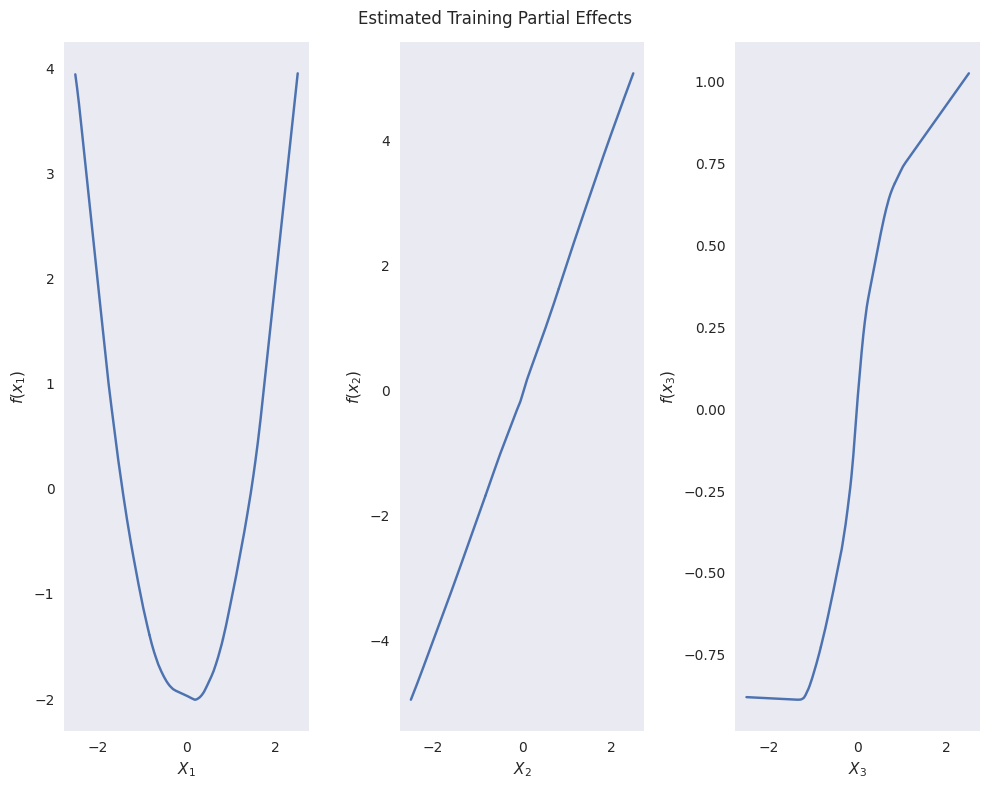

157/157 [==============================] - 0s 768us/step


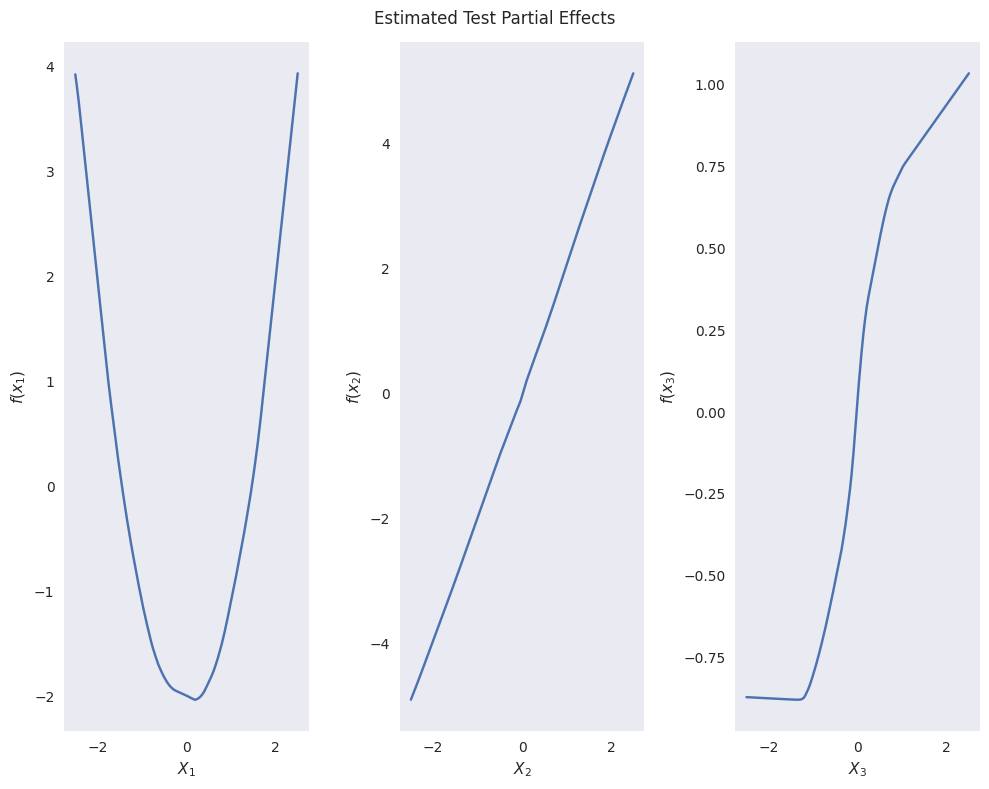

In [ ]:
from neuralGAM.plot import plot_partial_dependencies
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plot_partial_dependencies(x=X_train, fs=fs_train_estimated, title="Estimated Training Partial Effects")

fs_test_est = ngam.predict(X_test, type = "terms")
plot_partial_dependencies(x=X_test, fs=fs_test_est, title="Estimated Test Partial Effects")

Since we observe a linear fit for $X_2$ we can force a linear fit for this covariate (using the column name in X_train) using the `linear_terms` parameter:

In [ ]:
ngam = NeuralGAM(family="gaussian", num_units=units, learning_rate=learning_rate, linear_terms=['1'])

muhat, fs_train_estimated, eta = ngam.fit(X_train = X_train, 
                                y_train = y_train, 
                                max_iter_ls = 10, 
                                bf_threshold=10e-5,
                                ls_threshold=0.1,
                                max_iter_backfitting=10,
                                parallel=True)

plot_partial_dependencies(x=X_train, fs=fs_train_estimated, title=f"Estimated Training Partial Effects - force linear fit for $X_2$")


We can now use the trained NeuralGAM model to make predictions on unseen data, and compute the MSE between the trained and predicted estimations: 

In [ ]:
y_pred = ngam.predict(X_test, type = "response")
pred_err = mean_squared_error(y_test, y_pred)
print("MSE in the test set = {0}".format(str(pred_err)))

157/157 [==============================] - 0s 736us/step
MSE in the test set = 0.27236913806030244
